# Obtaining the 150 modes of variation ordered by explained variance

In [1]:
# Data manipulation
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc

# Graphic
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import matplotlib.dates as mdates
import seaborn as sns
from cartopy.crs import EqualEarth, PlateCarree
import geopandas as gpd
from shapely.geometry import Point

# PCA/EOF Analysis
from xeofs.models import EOF, EOFRotator, ExtendedEOF

# Statistics
from scipy import stats
from scipy.interpolate import griddata

In [2]:
def modes_to_pandas(rscores, rcomponents, n_modes):
    eof_temporal_data = pd.DataFrame()
    for i in range(1, n_modes+1):
        eof_aux = rscores.sel(mode=i).to_dataframe().reset_index()
        eof_temporal_data = pd.concat([eof_temporal_data, eof_aux])
        del eof_aux
    eof_temporal_data = eof_temporal_data.reset_index(drop=True)

    eof_spatial_data = pd.DataFrame()
    for i in range(1, n_modes+1):
        eof_aux = rcomponents.sel(mode=i).to_dataframe().reset_index()
        eof_aux.insert(3, 'lon_reshape', eof_aux.apply(lambda x: ((x.lon+180) % 360) - 180, axis=1))
        eof_spatial_data = pd.concat([eof_spatial_data, eof_aux])
        del eof_aux
    eof_spatial_data = eof_spatial_data.reset_index(drop=True)


    return eof_temporal_data, eof_spatial_data

<br>
<br>
<br>
<br>
<br>
<br>

# SST anomaly EOF analysis

NOAA ERSST Reanalysis Dataset V5: https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/

In [3]:
fp = '../data/sst.mnmean.nc'
sst = xr.open_dataset(fp)

Remove climatologies (obtain anomalies series): https://xeofs.readthedocs.io/en/latest/auto_examples/1single/plot_eeof_trend.html#sphx-glr-auto-examples-1single-plot-eeof-trend-py

In [7]:
anomaly_sst = sst['sst']
anomaly_sst = anomaly_sst.where(anomaly_sst.time <= np.datetime64('2020-12-01'), drop=True)
anomaly_sst = anomaly_sst.groupby("time.month") - anomaly_sst.groupby("time.month").mean("time")

In [11]:
eof_model_detrended = EOF(n_modes=150, standardize=False, use_coslat=True)
eof_model_detrended.fit(anomaly_sst, dim="time")

# VARIMAX rotation
rotator = EOFRotator(n_modes=150)
rotator.fit(eof_model_detrended)
expvar = rotator.explained_variance()
expvar_ratio = rotator.explained_variance_ratio()
rcomponents = rotator.components()
rscores = rotator.scores()

In [13]:
print("Explained variance: ", expvar.round(0).values)
print("\nRelative: ", (expvar_ratio * 100).round(1).values)

Explained variance:  [342.  73.  66.  61.  58.  54.  52.  49.  47.  44.  43.  43.  41.  41.
  39.  38.  38.  38.  37.  37.  36.  36.  34.  34.  34.  34.  34.  32.
  32.  32.  31.  30.  30.  30.  29.  28.  28.  28.  28.  28.  28.  27.
  27.  25.  25.  25.  23.  22.  22.  22.  22.  22.  22.  21.  21.  20.
  20.  20.  20.  19.  19.  19.  19.  19.  19.  19.  18.  17.  17.  17.
  17.  17.  17.  16.  16.  16.  15.  15.  15.  14.  14.  14.  14.  14.
  13.  13.  13.  13.  13.  13.  12.  12.  12.  11.  11.  11.  11.  11.
  11.  10.  10.  10.  10.  10.  10.   9.   9.   9.   9.   9.   9.   9.
   9.   9.   8.   8.   8.   7.   7.   7.   7.   7.   7.   6.   6.   6.
   6.   6.   6.   6.   5.   5.   5.   5.   5.   5.   5.   5.   5.   5.
   4.   4.   4.   4.   3.   3.   3.   3.   3.   2.]

Relative:  [10.4  2.2  2.   1.8  1.7  1.6  1.6  1.5  1.4  1.3  1.3  1.3  1.2  1.2
  1.2  1.2  1.2  1.2  1.1  1.1  1.1  1.1  1.   1.   1.   1.   1.   1.
  1.   1.   0.9  0.9  0.9  0.9  0.9  0.9  0.9  0.8  0.8  0.8  0.

In [14]:
plt.style.use('seaborn')

C:\Users\mathe\AppData\Local\Temp\ipykernel_11432\240305066.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


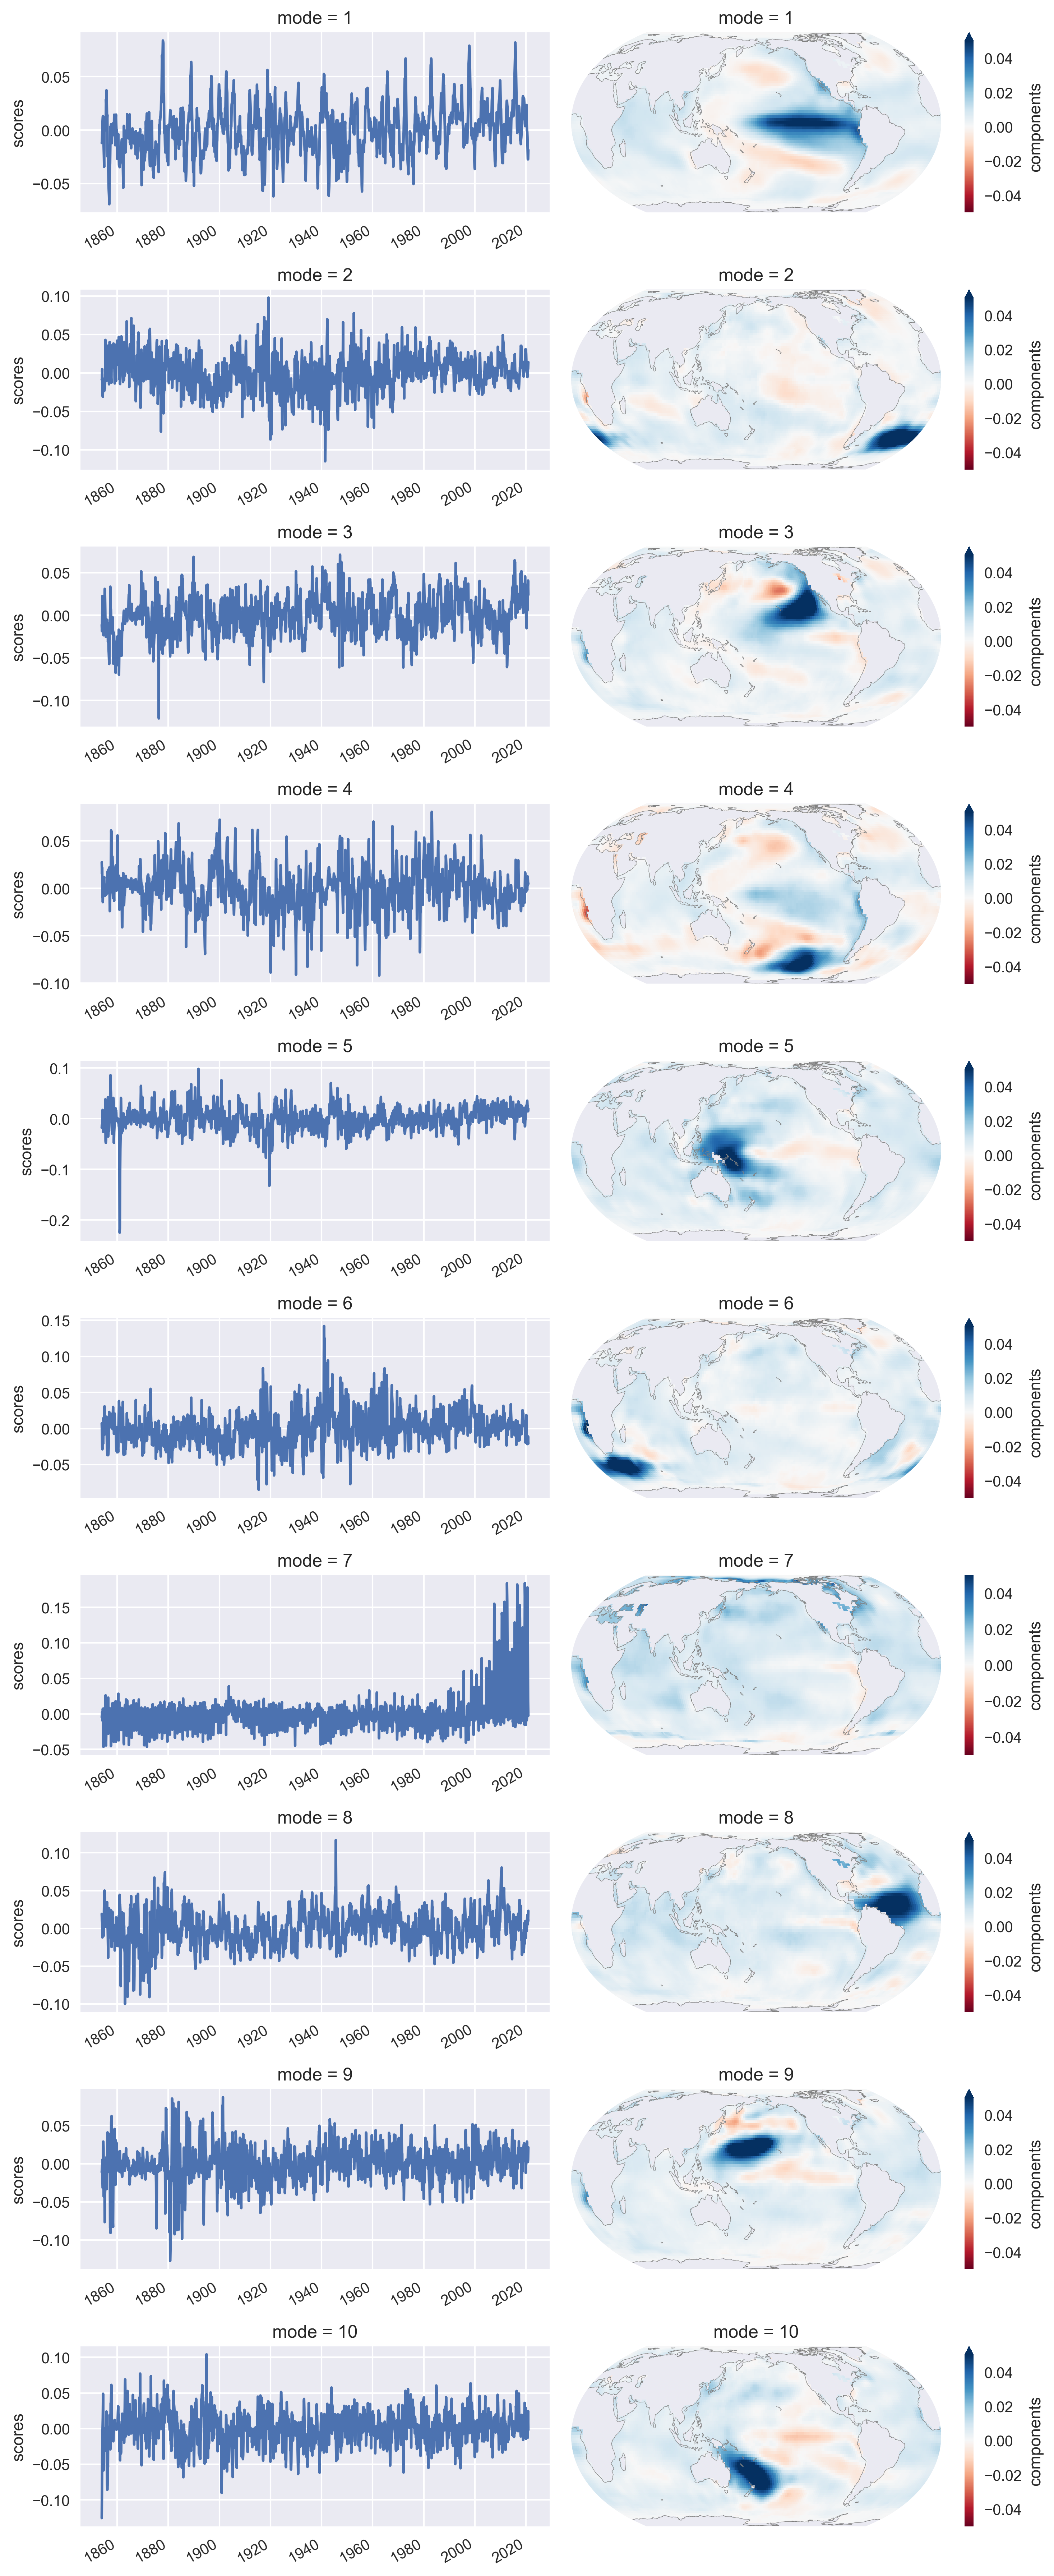

In [15]:
initial_mode=1

proj = EqualEarth(central_longitude=180)
kwargs = {"cmap": "RdBu", "vmin": -0.05, "vmax": 0.05, "transform": PlateCarree()}

fig = plt.figure(figsize=(10, 24), dpi=300)
gs = GridSpec(10, 2, width_ratios=[1, 1])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(10)]
ax1 = [fig.add_subplot(gs[i, 1], projection=proj) for i in range(10)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    rscores.sel(mode=i + initial_mode).plot(ax=a0)
    a1.coastlines(color=".5")
    rcomponents.sel(mode=i + initial_mode).plot(ax=a1, **kwargs)

    a0.set_xlabel("")

plt.tight_layout()

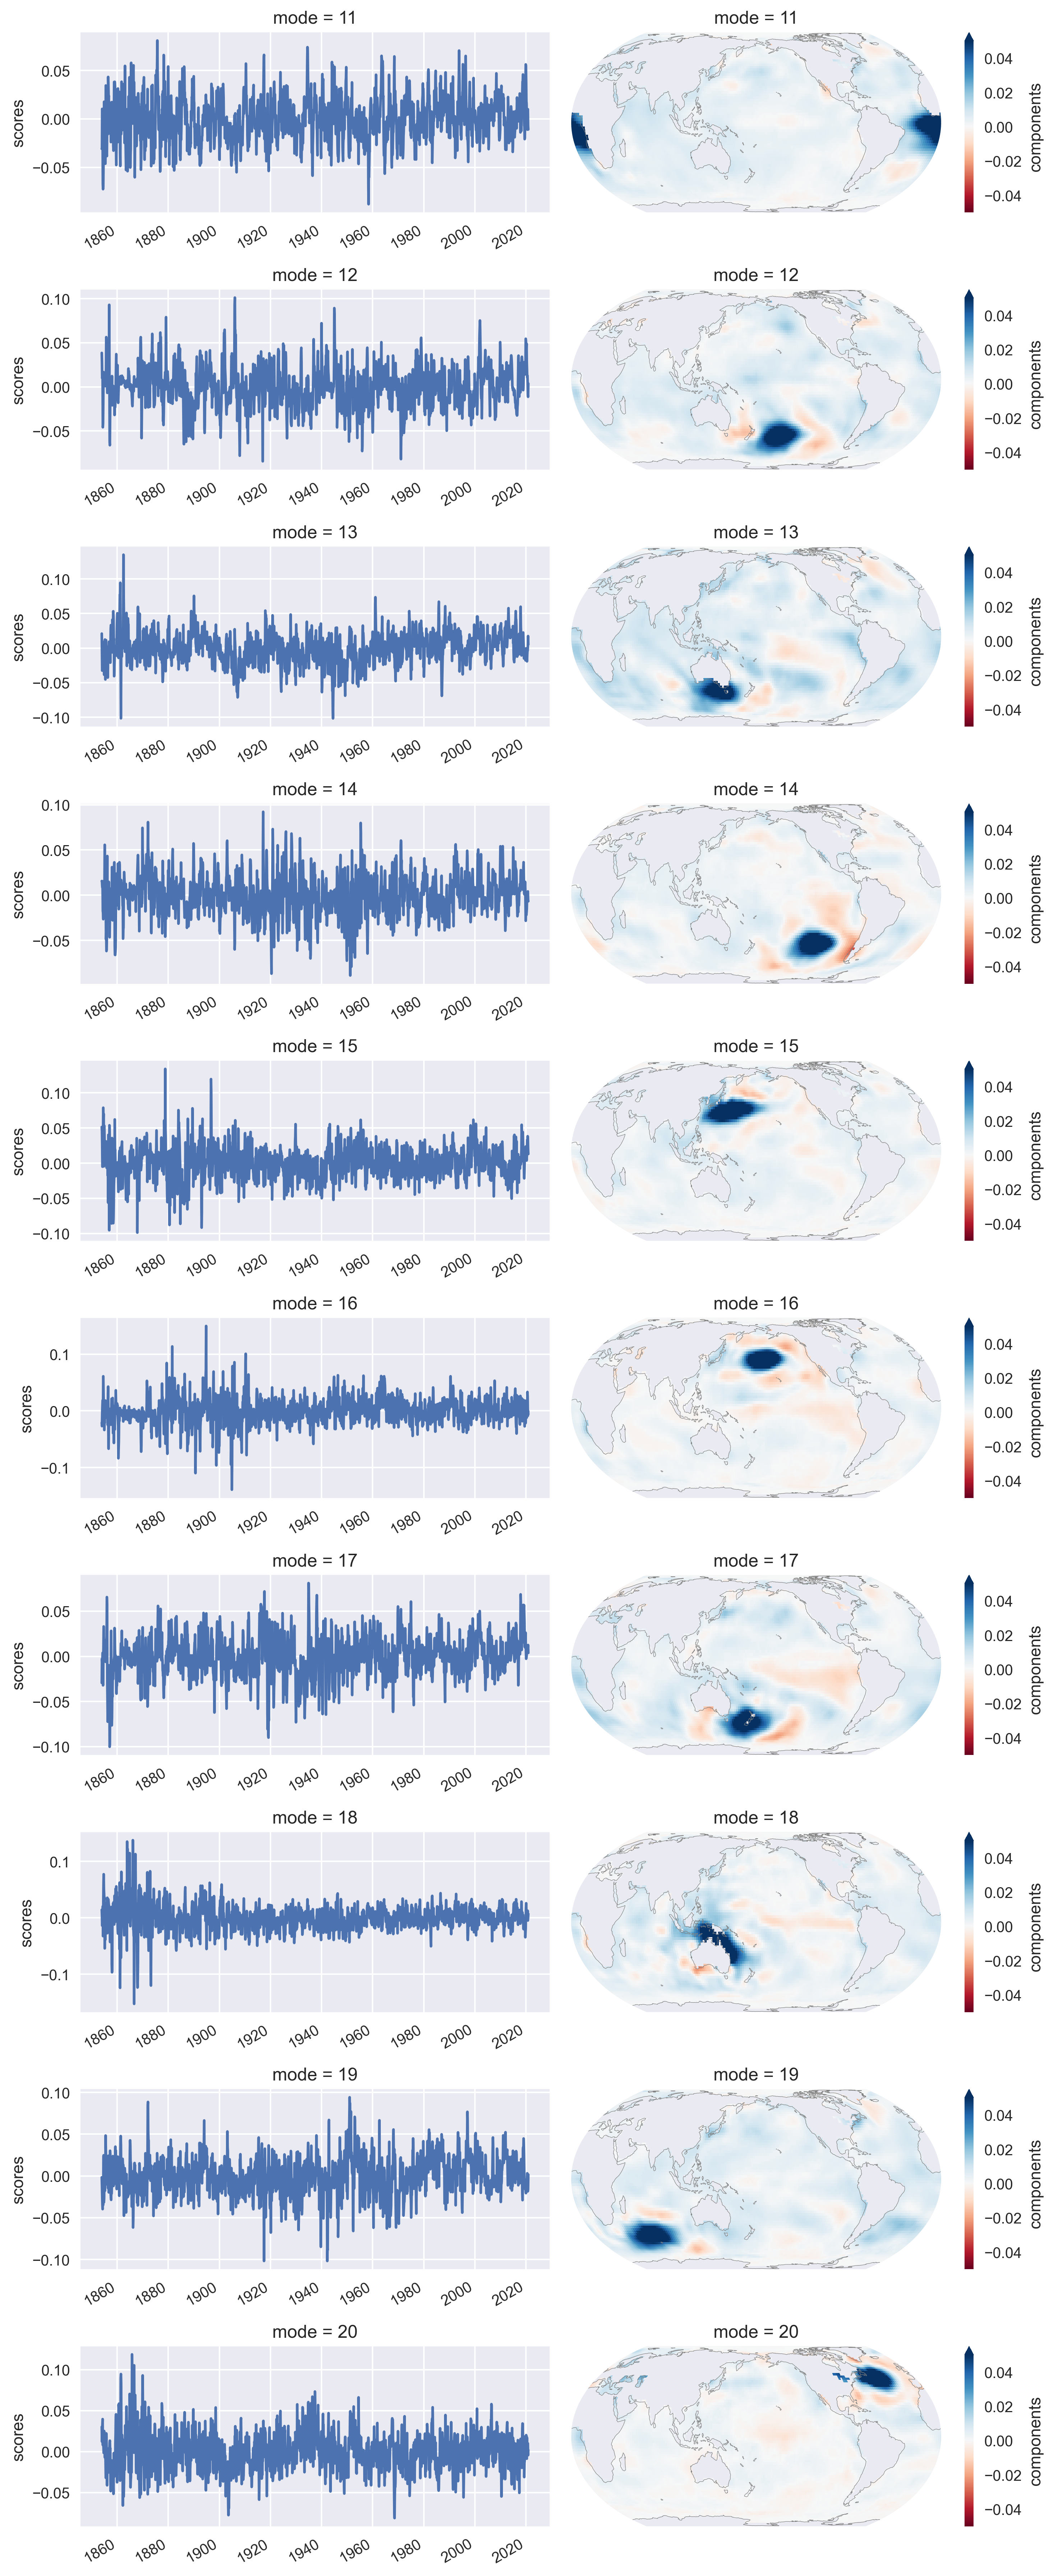

In [16]:
initial_mode=11

proj = EqualEarth(central_longitude=180)
kwargs = {"cmap": "RdBu", "vmin": -0.05, "vmax": 0.05, "transform": PlateCarree()}

fig = plt.figure(figsize=(10, 24), dpi=300)
gs = GridSpec(10, 2, width_ratios=[1, 1])
ax0 = [fig.add_subplot(gs[i, 0]) for i in range(10)]
ax1 = [fig.add_subplot(gs[i, 1], projection=proj) for i in range(10)]

for i, (a0, a1) in enumerate(zip(ax0, ax1)):
    rscores.sel(mode=i + initial_mode).plot(ax=a0)
    a1.coastlines(color=".5")
    rcomponents.sel(mode=i + initial_mode).plot(ax=a1, **kwargs)

    a0.set_xlabel("")

plt.tight_layout()

In [17]:
sst_temporal_data, sst_spatial_data = modes_to_pandas(rscores=rscores, rcomponents=rcomponents, n_modes=150)

In [18]:
sst_temporal_data

time  month  mode    scores
0      1854-01-01      1     1 -0.012051
1      1854-02-01      2     1 -0.011179
2      1854-03-01      3     1 -0.003110
3      1854-04-01      4     1  0.005516
4      1854-05-01      5     1  0.008401
...           ...    ...   ...       ...
300595 2020-08-01      8   150  0.019782
300596 2020-09-01      9   150 -0.024550
300597 2020-10-01     10   150  0.006711
300598 2020-11-01     11   150 -0.015127
300599 2020-12-01     12   150  0.018041

[300600 rows x 4 columns]

In [19]:
sst_spatial_data

lat    lon  mode  lon_reshape  components
0       -88.0    0.0     1          0.0         NaN
1       -88.0    2.0     1          2.0         NaN
2       -88.0    4.0     1          4.0         NaN
3       -88.0    6.0     1          6.0         NaN
4       -88.0    8.0     1          8.0         NaN
...       ...    ...   ...          ...         ...
2402995  88.0  350.0   150        -10.0   -0.000002
2402996  88.0  352.0   150         -8.0   -0.000002
2402997  88.0  354.0   150         -6.0   -0.000002
2402998  88.0  356.0   150         -4.0   -0.000003
2402999  88.0  358.0   150         -2.0   -0.000003

[2403000 rows x 5 columns]

In [20]:
sst_temporal_data.to_csv('../data/processed/sst_modes150_temporal_data_noaa.csv', index=False)
sst_spatial_data.to_csv('../data/processed/sst_modes150_spatial_data_noaa.csv', index=False)